<a href="https://colab.research.google.com/github/rafaelrpq/classificadores/blob/main/classifcador%5B_em_atualizacao_%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atenção

- Para melhor desempenho durante a execução no Google Colab vá em *Ambiente de execução* » *Alterar o tipo de ambiente de execução* e selecione *T4 GPU*


- [x] adicionar metricas TP - TN - FP - FN
- [ ]



In [1]:
!git clone https://github.com/iman2693/CTCB.git > /dev/null 2>&1
!cp -r CTCB/dataset ./

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoFeatureExtractor, AutoModel
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import warnings

In [3]:
class FeatureExtractor :
    def __init__ (self, vit) :
        self.model = AutoModel.from_pretrained (vit).to (device)
        self.model.eval ()

    def extract_features (self, dataloader):
        features, labels = [], []
        for inputs, targets in dataloader:
            inputs = inputs.to (device)  # Mover inputs para o dispositivo
            with torch.no_grad ():
                outputs = self.model (inputs)["last_hidden_state"]
                cls_tokens = outputs[:, 0, :].cpu ().numpy ()  # Mover para CPU para conversão em numpy
            features.append (cls_tokens)
            labels.append (targets.numpy ())
        return np.vstack (features), np.hstack (labels)

In [4]:
class Classifier :
    def __init__ (self, name, clf) :
        self.name = name
        self.clf = clf

    def train_predict (self, X_train, y_train, X_val, y_val, hyperparameters) :
        data = []
        for params in hyperparameters[self.name]:
            clf = self.clf (**params)
            clf.fit (X_train, y_train)
            y_pred = clf.predict (X_val)

            data.append ({
                "params" :  params,
                "y_pred" : y_pred,
                "y_val"  : y_val
            })

        return data

    def test_predict (self, X_test, y_test, hyperparameters) :
        data = []
        for params in hyperparameters[self.name]:
            clf = self.clf (**params)
            clf.fit (X_test, y_test)
            y_pred = clf.predict (X_test)

            data.append ({
                "params" :  params,
                "y_pred" : y_pred,
                "y_val"  : y_test
            })

        return data

In [5]:
def train_evaluate (train) :
    results = []
    for fold in train :
        results.append ([])
        for data in fold :
            y_pred = data["y_pred"]
            y_val = data["y_val"]
            acc = accuracy_score (y_val, y_pred)
            precision = precision_score (y_val, y_pred, average="macro", zero_division=0)
            recall = recall_score (y_val, y_pred, average="macro", zero_division=0)
            f1 = f1_score (y_val, y_pred, average="macro")

            results.append ({
                "param" :  data["params"],
                "accuracy": acc,
                "precision": precision,
                "recall": recall,
                "f1": f1
            })
    return results

In [6]:
# Configurar dispositivo (GPU se disponível)
device = torch.device ("cuda" if torch.cuda.is_available () else "cpu")
print (f"Usando o dispositivo: {device}")

# Hiperparametros
hyperparameters = {
    "SVM": [{"C": c} for c in [0.1, 1, 10, 100, 1000]],
    "MLP": [{"hidden_layer_sizes": hls} for hls in [(50,), (100,), (50, 50), (100, 100), (200, 200)]],
    "RandomForest": [{"n_estimators": n} for n in [10, 50, 100, 200, 500]],
    "KNN": [{"n_neighbors": k} for k in [1, 3, 5, 7, 9]]
}


# Transformação das imagens
transform = transforms.Compose ([
    transforms.Resize ((224, 224)),
    transforms.ToTensor (),
    transforms.Normalize (mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Diretório das imagens
data_dir = "./dataset/Train/"

# Carregar o conjunto de dados
dataset = datasets.ImageFolder (root=data_dir, transform=transform)

# Dividir o dataset em treino e teste
test_ratio = 0.2
train_dataset, test_dataset = train_test_split(dataset, test_size=test_ratio, random_state=42)

# KFold
k_folds = 5
batch_size = 16

kf = KFold (n_splits=k_folds, shuffle=True, random_state=42)

warnings.filterwarnings("ignore")

# Instanciando Extratores de Caracteristicas baseados em ViT Models
dino = FeatureExtractor("facebook/dino-vitb8")
# vitB = FeatureExtractor("google/vit-base-patch16-224")
# vitL = FeatureExtractor("google/vit-large-patch16-224")

# Instanciando Classificadores
classifiers = {
    'svm' : Classifier("SVM", SVC),
    'mlp' : Classifier("MLP", MLPClassifier),
    'rf'  : Classifier("RandomForest", RandomForestClassifier),
    'knn' : Classifier("KNN", KNeighborsClassifier),
}

dino_train = {
    'svm' : [],
    'mlp' : [],
    'rf'  : [],
    'knn' : [],
}
# vitB_train = {
#     'svm' : [],
#     'mlp' : [],
#     'rf'  : [],
#     'knn' : [],
# }
# vitL_train = {
#     'svm' : [],
#     'mlp' : [],
#     'rf'  : [],
#     'knn' : [],
# }

Usando o dispositivo: cuda


config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Rotina de treinamento
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Subsets
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Extrair características
    X_train, y_train = dino.extract_features (train_loader)
    X_val, y_val = dino.extract_features (val_loader)

    # Estrutura para armazenar resultados por fold
    fold_results = {
        'svm' : [],
        'mlp' : [],
        'rf'  : [],
        'knn' : [],
    }

    for classifier_name, classifier_instance in classifiers.items():
        train_data = classifier_instance.train_predict(X_train, y_train, X_val, y_val, hyperparameters)
        for data in train_data:
            y_pred = data["y_pred"]
            y_val = data["y_val"]
            acc = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average="macro", zero_division=0)
            recall = recall_score(y_val, y_pred, average="macro", zero_division=0)
            f1 = f1_score(y_val, y_pred, average="macro")

            fold_results[classifier_name].append({
                "params": data["params"],
                "accuracy": acc,
                "precision": precision,
                "recall": recall,
                "f1": f1
            })

    # Adicionar os resultados do fold à estrutura geral
    for classifier_name in dino_train:
        dino_train[classifier_name].append(fold_results[classifier_name])

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [8]:
print(dino_train['svm'])

[[{'params': {'C': 0.1}, 'accuracy': 0.7620481927710844, 'precision': 0.4339190392508101, 'recall': 0.4218390113018956, 'f1': 0.36985934254697544}, {'params': {'C': 1}, 'accuracy': 0.9307228915662651, 'precision': 0.9269208759456986, 'recall': 0.8592886209291277, 'f1': 0.8790574651527105}, {'params': {'C': 10}, 'accuracy': 0.9487951807228916, 'precision': 0.9225066291257108, 'recall': 0.909607637424615, 'f1': 0.9151163759723657}, {'params': {'C': 100}, 'accuracy': 0.9487951807228916, 'precision': 0.9225066291257108, 'recall': 0.909607637424615, 'f1': 0.9151163759723657}, {'params': {'C': 1000}, 'accuracy': 0.9487951807228916, 'precision': 0.9225066291257108, 'recall': 0.909607637424615, 'f1': 0.9151163759723657}], [{'params': {'C': 0.1}, 'accuracy': 0.7259036144578314, 'precision': 0.26176359872012045, 'recall': 0.37169444444444444, 'f1': 0.3000919016323381}, {'params': {'C': 1}, 'accuracy': 0.9186746987951807, 'precision': 0.8289435564435564, 'recall': 0.7250799390667811, 'f1': 0.7477

In [9]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
X_test, y_test = dino.extract_features(test_loader)

svm_test = classifiers['svm'].test_predict (X_test, y_test, hyperparameters)
mlp_test = classifiers['mlp'].test_predict (X_test, y_test, hyperparameters)
rf_test  = classifiers['rf'].test_predict (X_test, y_test, hyperparameters)
knn_test = classifiers['knn'].test_predict (X_test, y_test, hyperparameters)

In [10]:
def test_evaluate (test) :
    results = []
    for data in test :
        y_pred = data["y_pred"]
        y_val = data["y_val"]
        acc = accuracy_score (y_val, y_pred)
        precision = precision_score (y_val, y_pred, average="macro", zero_division=0)
        recall = recall_score (y_val, y_pred, average="macro", zero_division=0)
        f1 = f1_score (y_val, y_pred, average="macro")

        results.append ({
            "param" :  data["params"],
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1
        })
    return results



In [11]:
test_evaluate (svm_test)

[{'param': {'C': 0.1},
  'accuracy': 0.472289156626506,
  'precision': 0.31198246922790007,
  'recall': 0.15658823529411764,
  'f1': 0.14874831616437373},
 {'param': {'C': 1},
  'accuracy': 0.9710843373493976,
  'precision': 0.8751393534002231,
  'recall': 0.854625237191651,
  'f1': 0.8625549322188129},
 {'param': {'C': 10},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'C': 100},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'C': 1000},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0}]

In [12]:
test_evaluate (mlp_test)

[{'param': {'hidden_layer_sizes': (50,)},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'hidden_layer_sizes': (100,)},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'hidden_layer_sizes': (50, 50)},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'hidden_layer_sizes': (100, 100)},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'hidden_layer_sizes': (200, 200)},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0}]

In [13]:
test_evaluate (rf_test)

[{'param': {'n_estimators': 10},
  'accuracy': 0.9927710843373494,
  'precision': 0.9940120452107912,
  'recall': 0.9915483870967743,
  'f1': 0.9927308619263524},
 {'param': {'n_estimators': 50},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'n_estimators': 100},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'n_estimators': 200},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'n_estimators': 500},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0}]

In [14]:
test_evaluate (knn_test)

[{'param': {'n_neighbors': 1},
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'param': {'n_neighbors': 3},
  'accuracy': 0.944578313253012,
  'precision': 0.8224459361228476,
  'recall': 0.8267628083491461,
  'f1': 0.8228588305118917},
 {'param': {'n_neighbors': 5},
  'accuracy': 0.9036144578313253,
  'precision': 0.7828730495599766,
  'recall': 0.7636301918616909,
  'f1': 0.7634578853149192},
 {'param': {'n_neighbors': 7},
  'accuracy': 0.8457831325301205,
  'precision': 0.7299890853248384,
  'recall': 0.6706145899219902,
  'f1': 0.6893539741894089},
 {'param': {'n_neighbors': 9},
  'accuracy': 0.8216867469879519,
  'precision': 0.7098086565889267,
  'recall': 0.6315028462998102,
  'f1': 0.6532850105513243}]

In [15]:
def gerar_matriz_confusao(data):

    y_pred = data["y_pred"]
    y_val = data["y_val"]

    matriz_confusao = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # return matriz_confusao

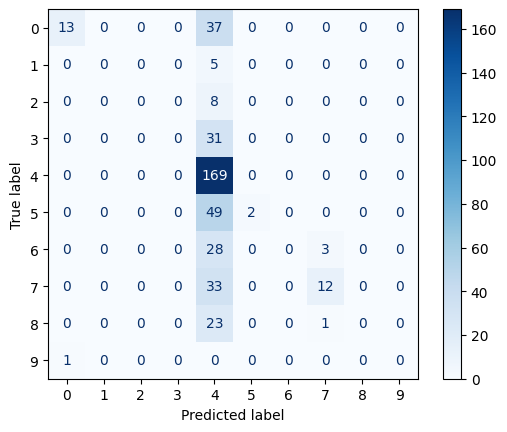

{'C': 0.1}


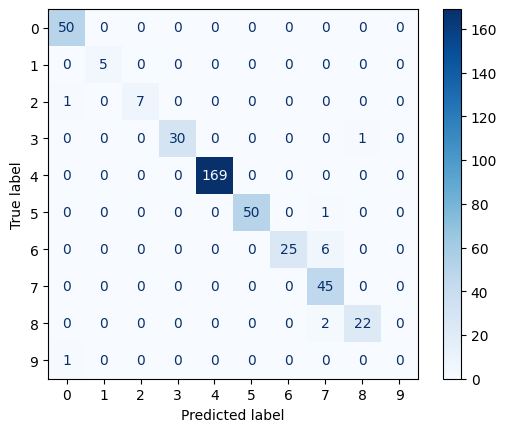

{'C': 1}


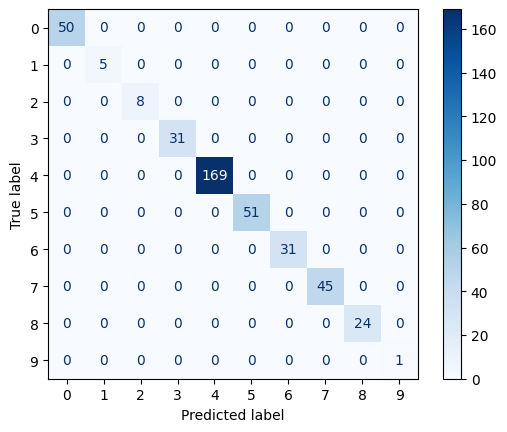

{'C': 10}


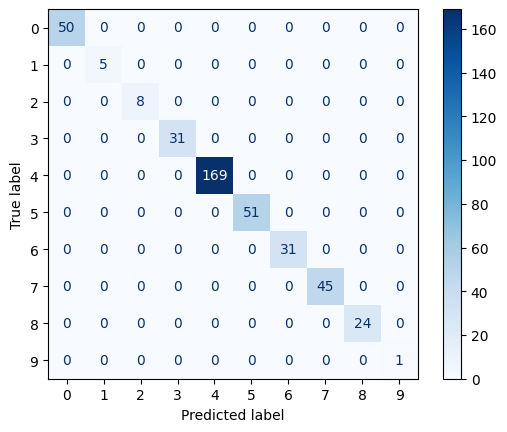

{'C': 100}


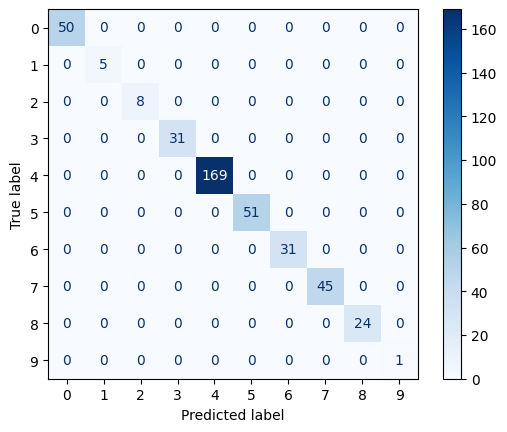

{'C': 1000}


In [16]:
for data in svm_test :
    gerar_matriz_confusao(data)
    print(data['params'])

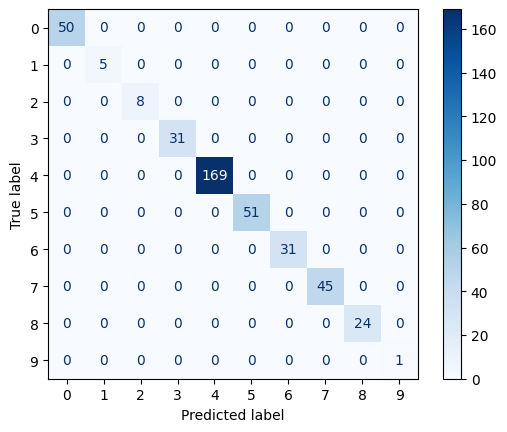

{'hidden_layer_sizes': (50,)}


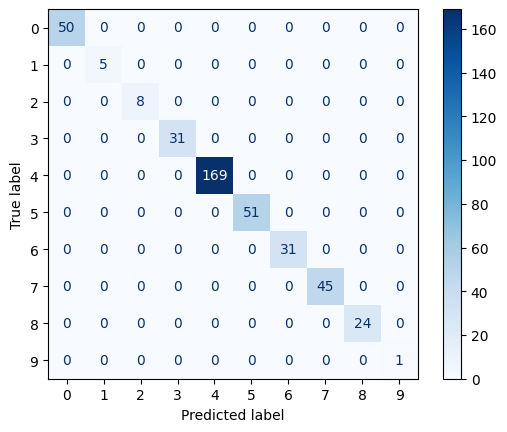

{'hidden_layer_sizes': (100,)}


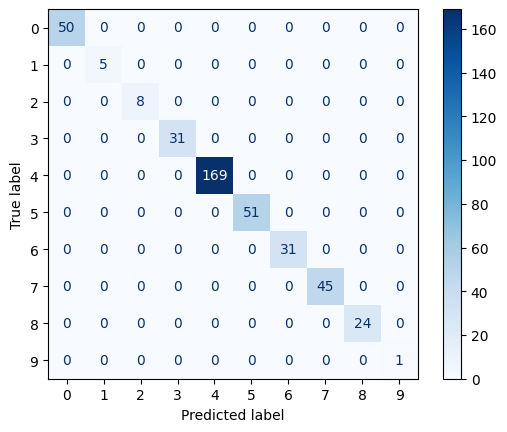

{'hidden_layer_sizes': (50, 50)}


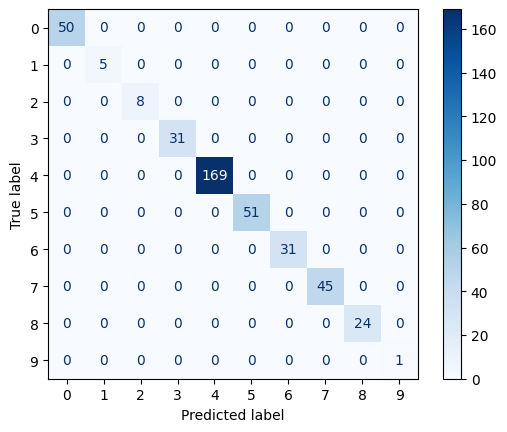

{'hidden_layer_sizes': (100, 100)}


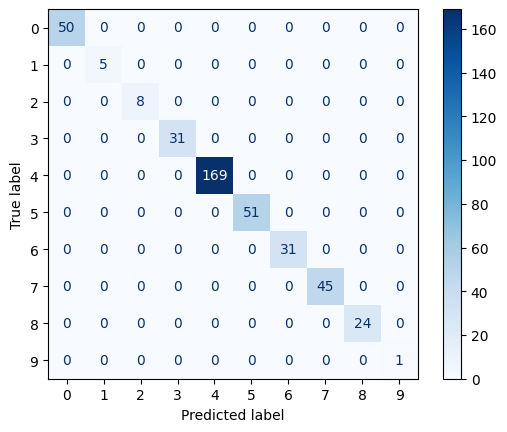

{'hidden_layer_sizes': (200, 200)}


In [17]:
for data in mlp_test :
    gerar_matriz_confusao(data)
    print(data['params'])

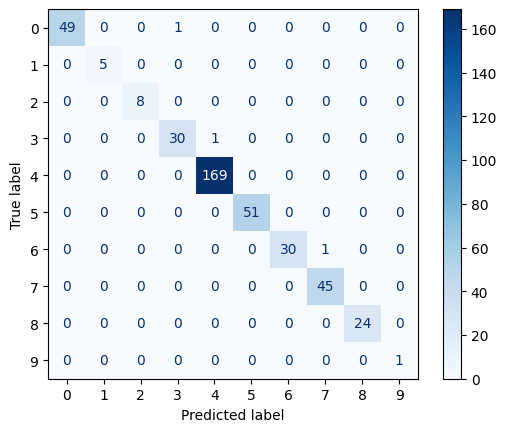

{'n_estimators': 10}


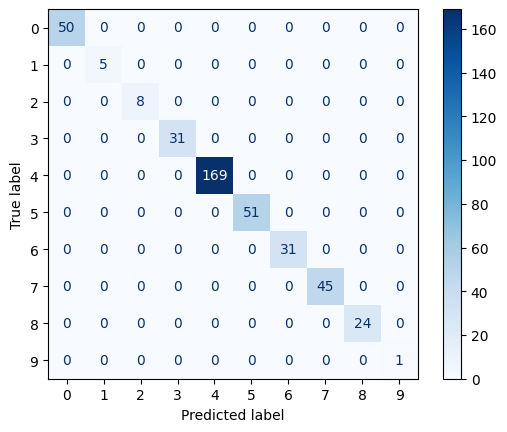

{'n_estimators': 50}


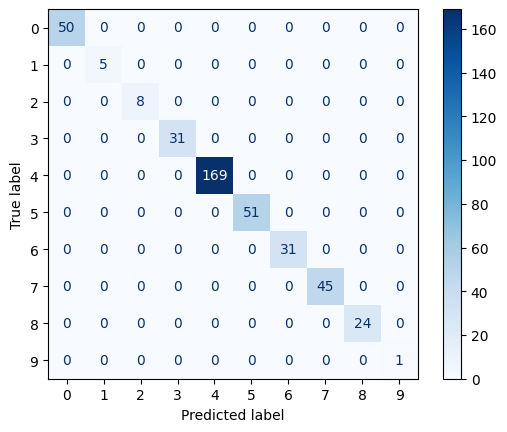

{'n_estimators': 100}


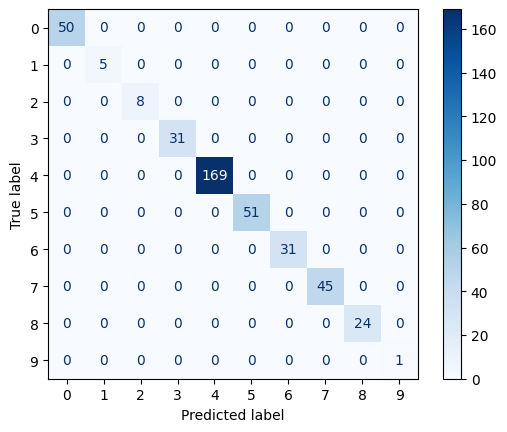

{'n_estimators': 200}


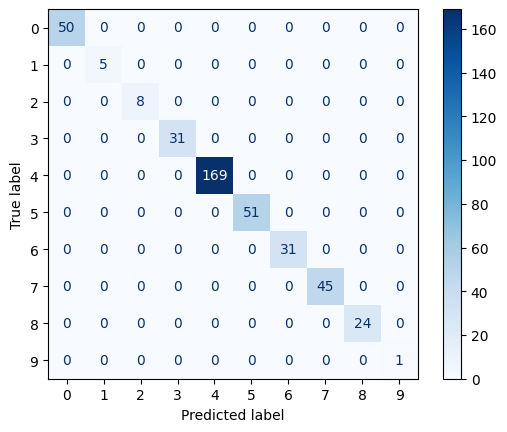

{'n_estimators': 500}


In [18]:
for data in rf_test :
    gerar_matriz_confusao(data)
    print(data['params'])

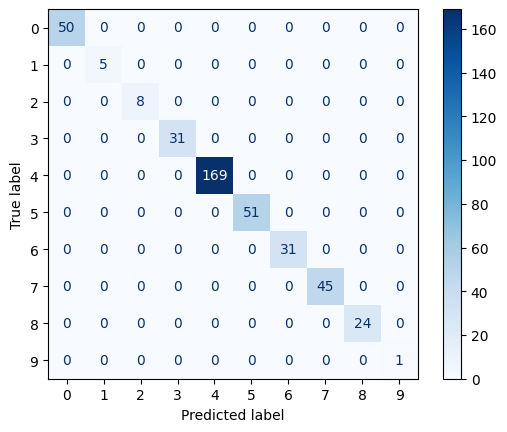

{'n_neighbors': 1}


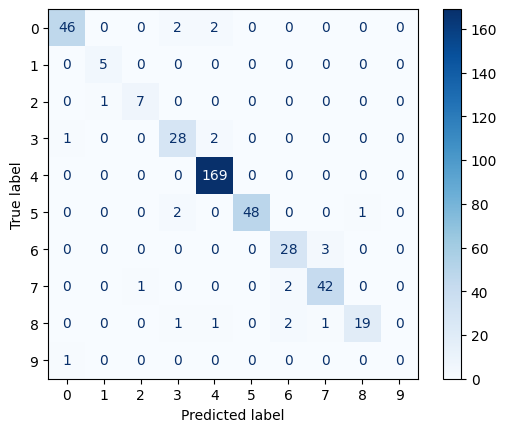

{'n_neighbors': 3}


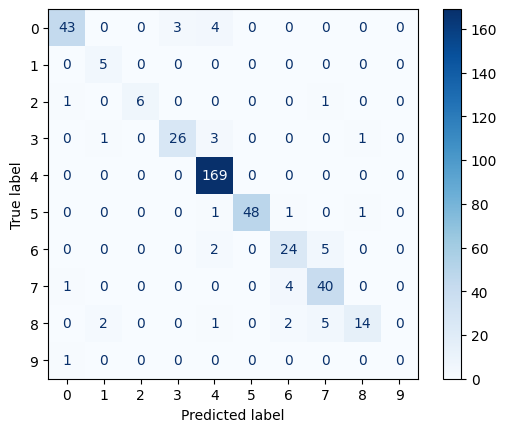

{'n_neighbors': 5}


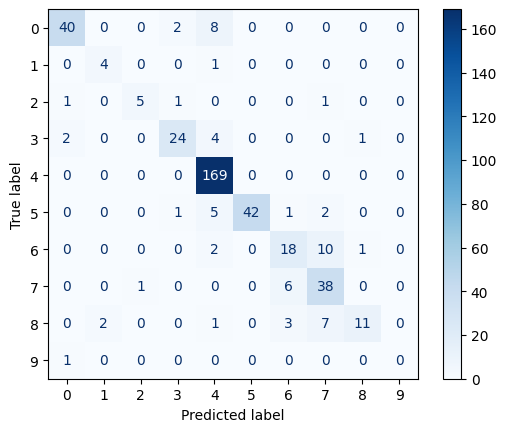

{'n_neighbors': 7}


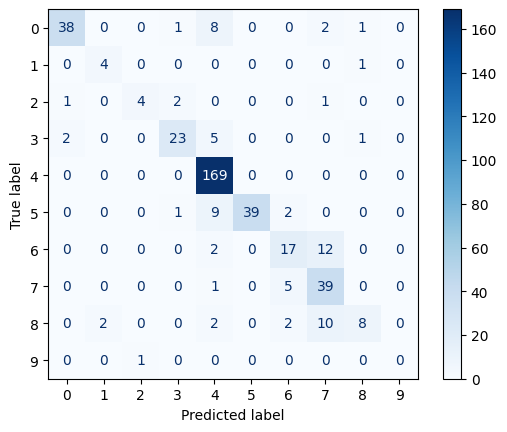

{'n_neighbors': 9}


In [19]:
for data in knn_test :
    gerar_matriz_confusao(data)
    print(data['params'])

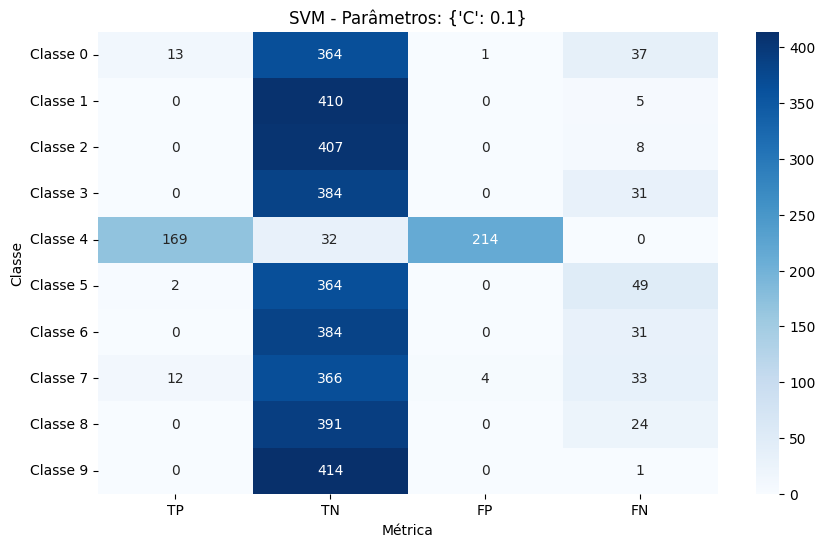

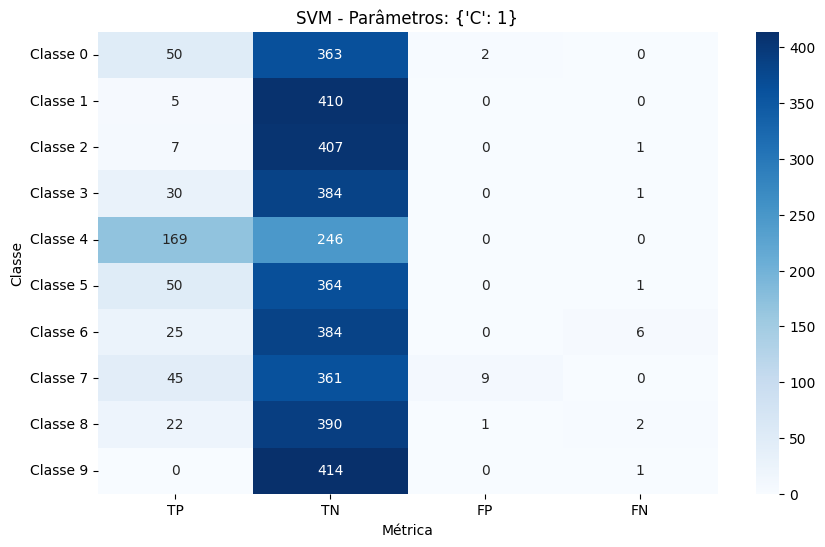

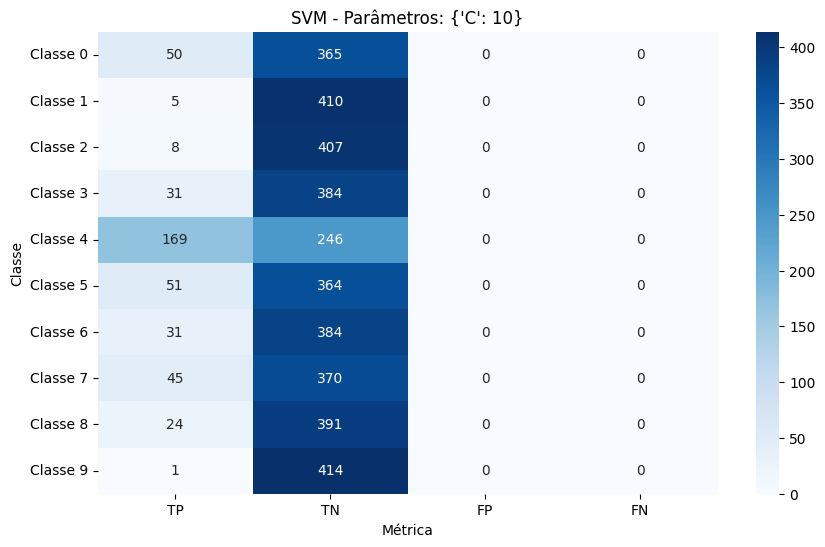

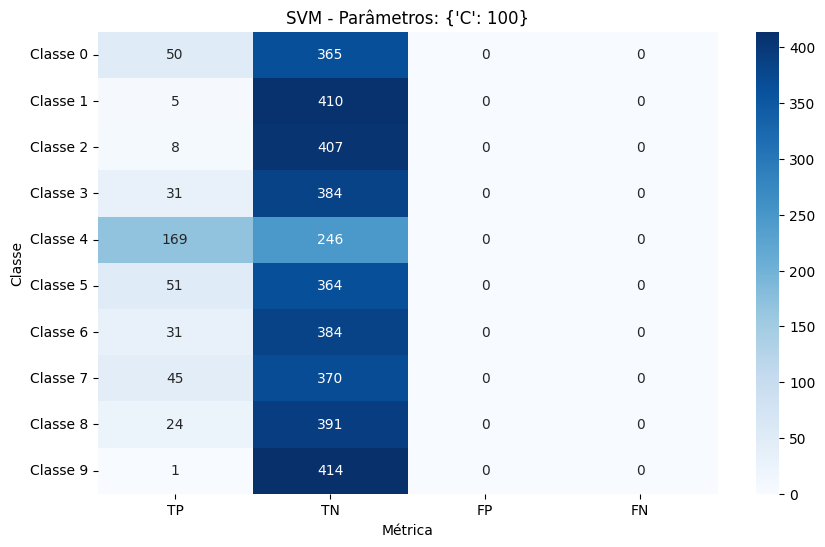

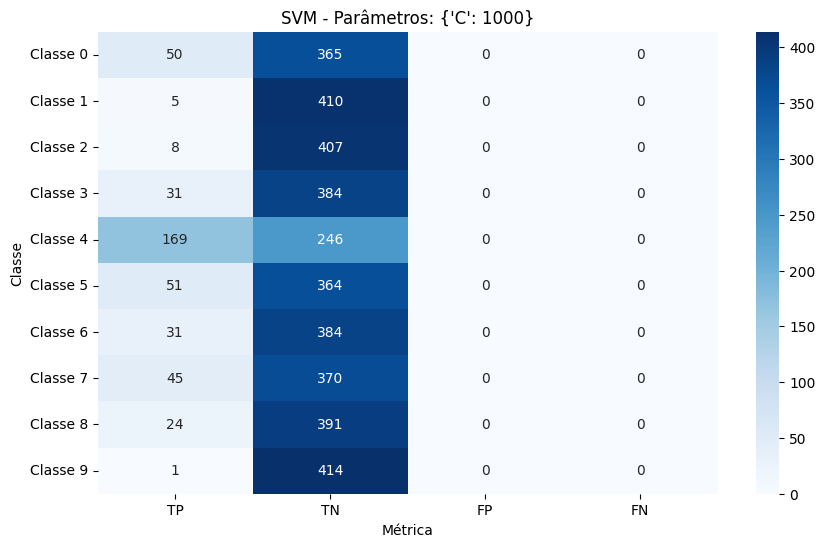

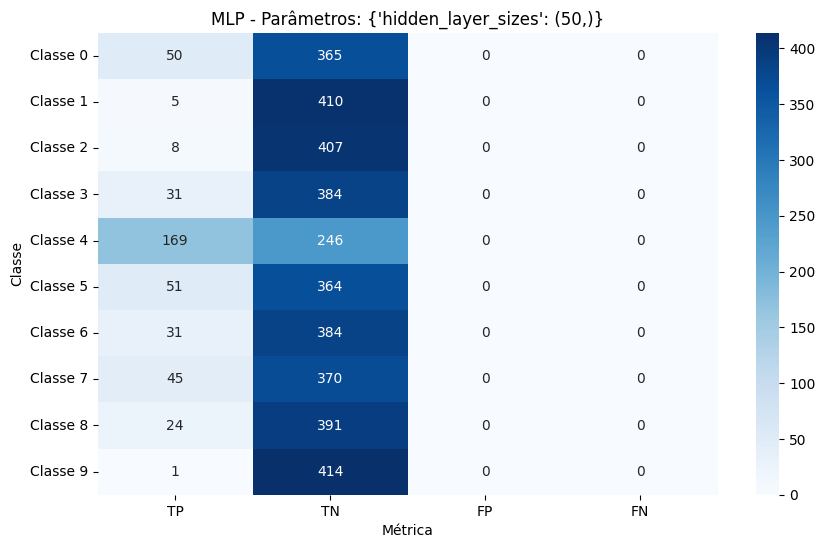

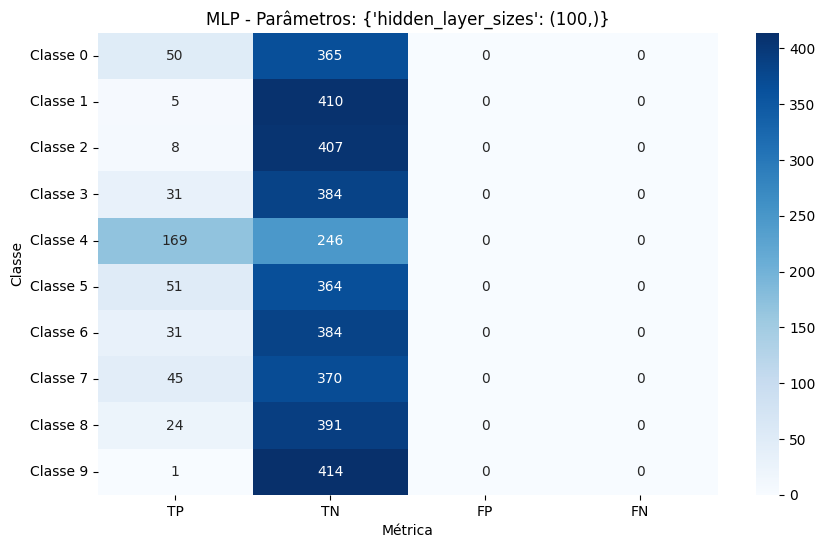

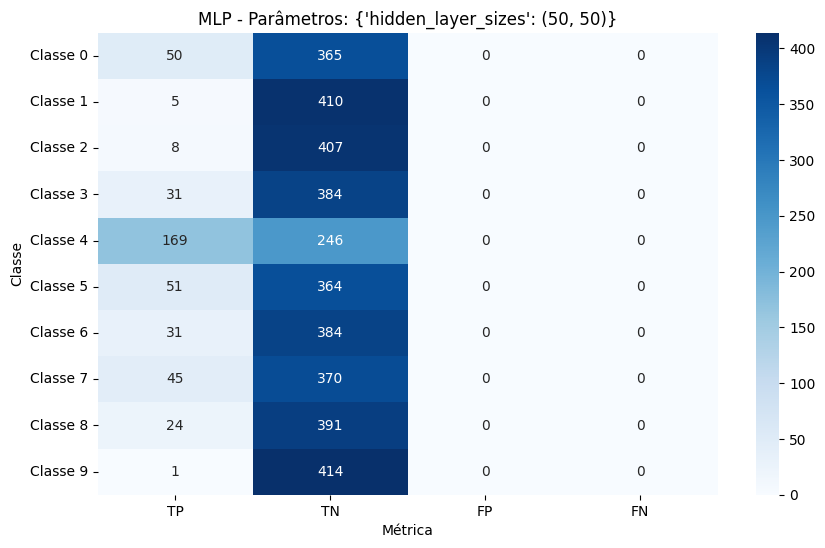

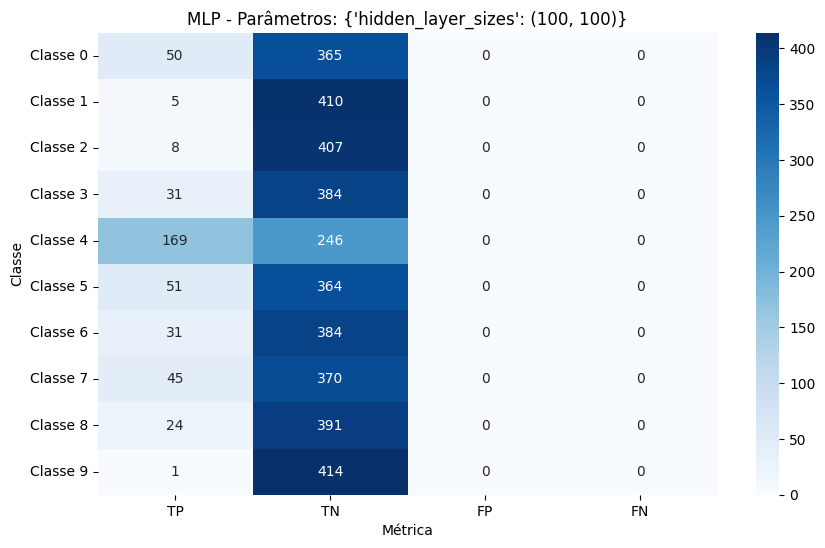

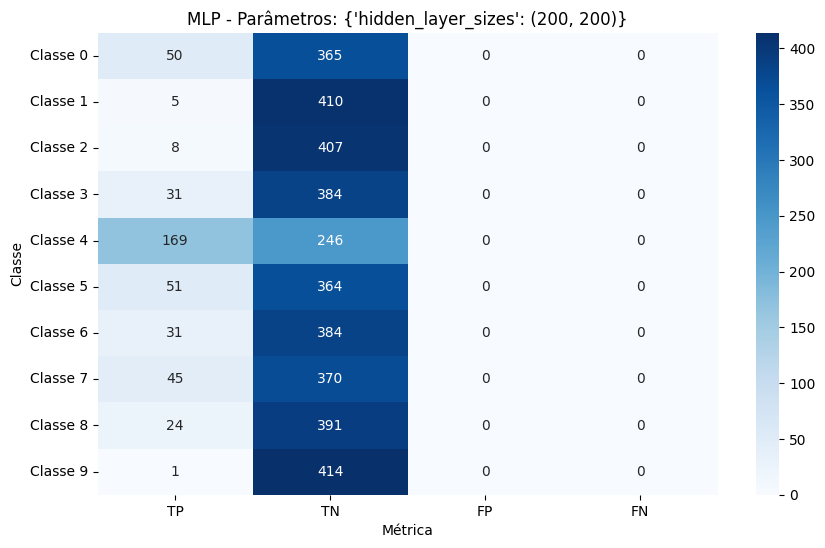

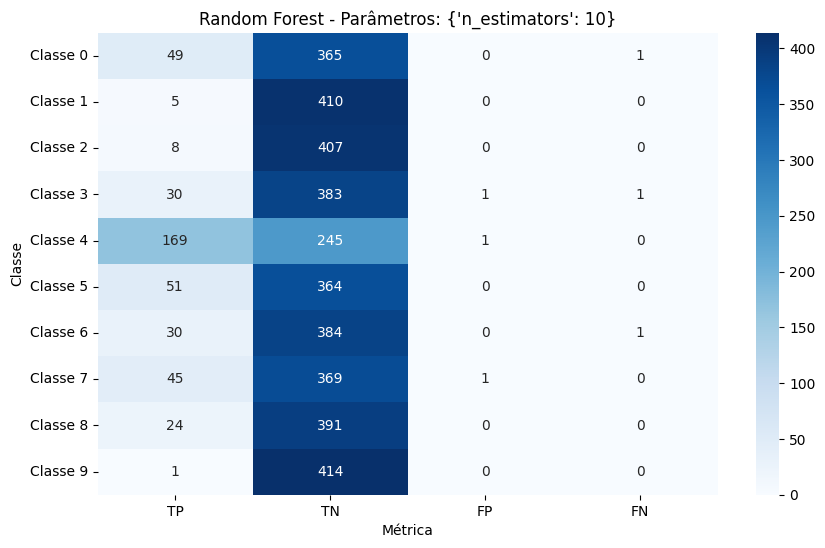

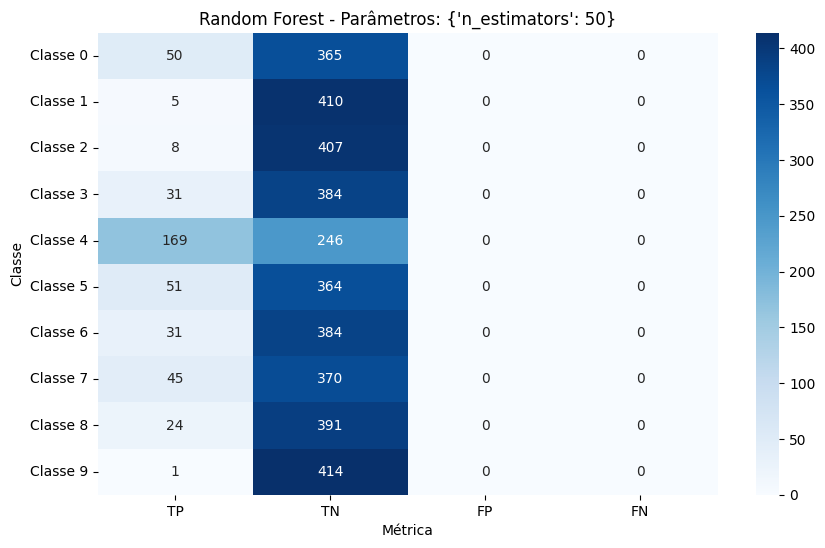

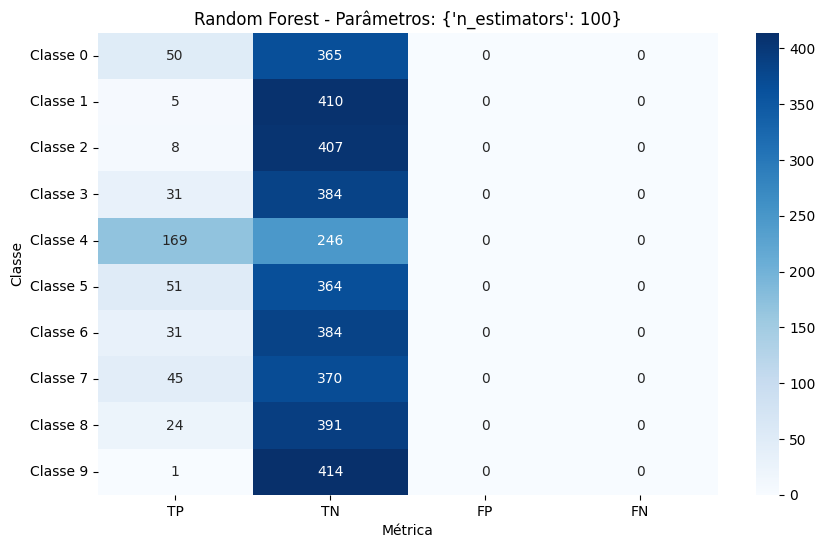

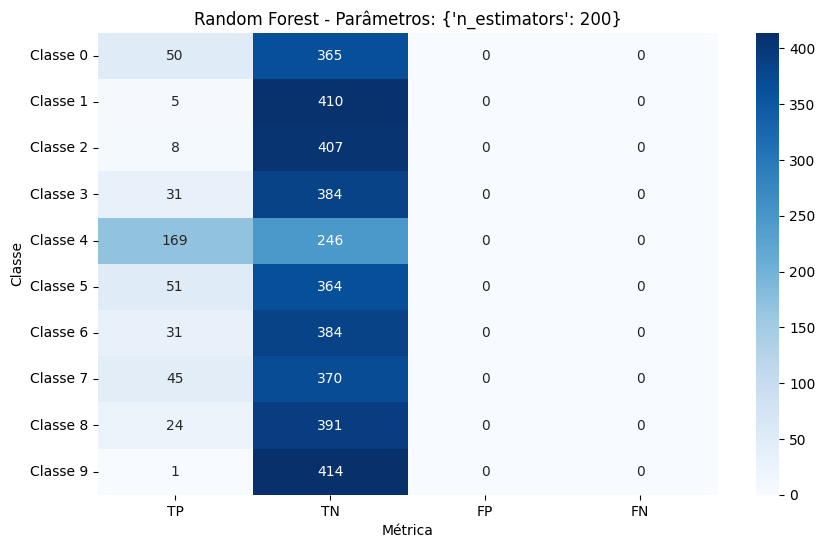

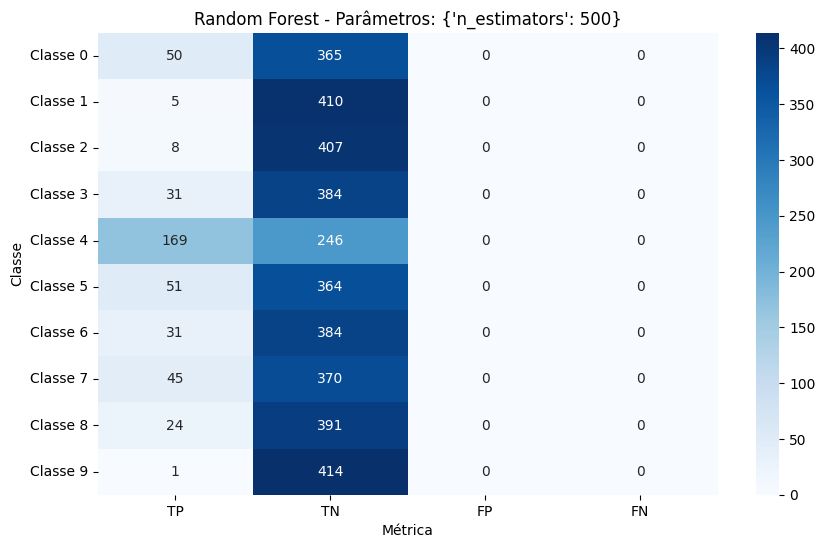

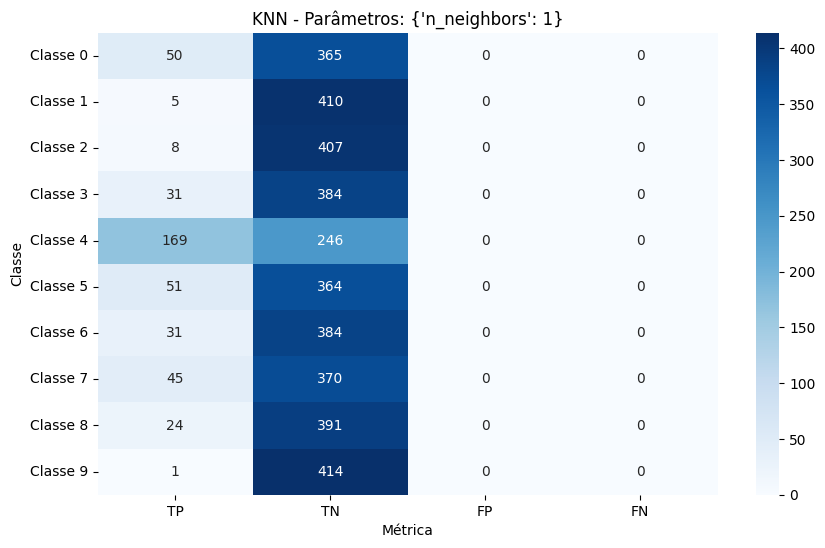

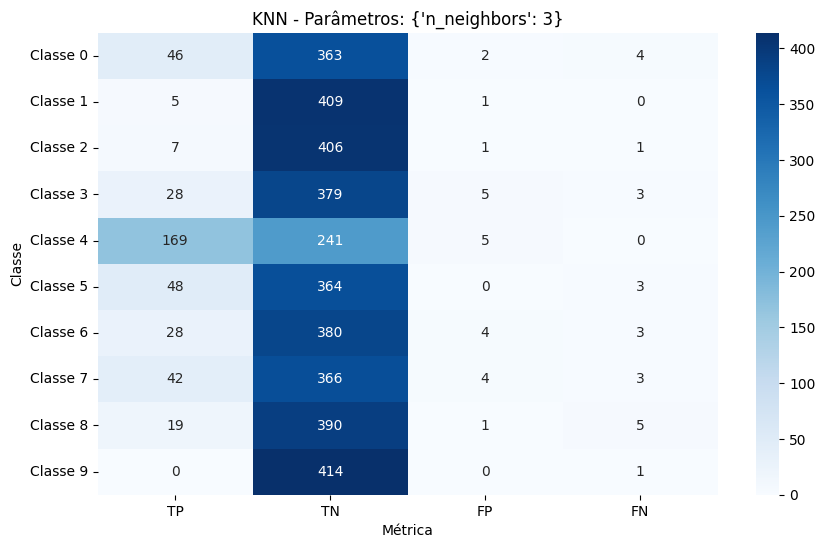

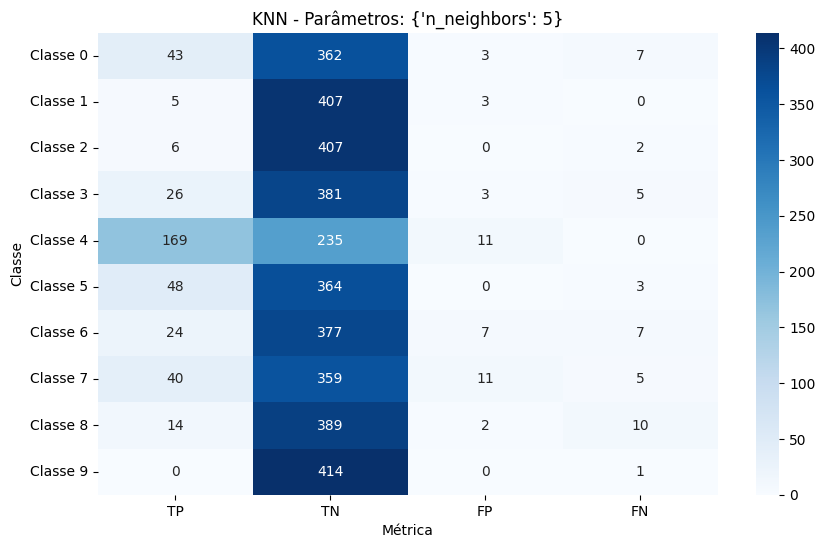

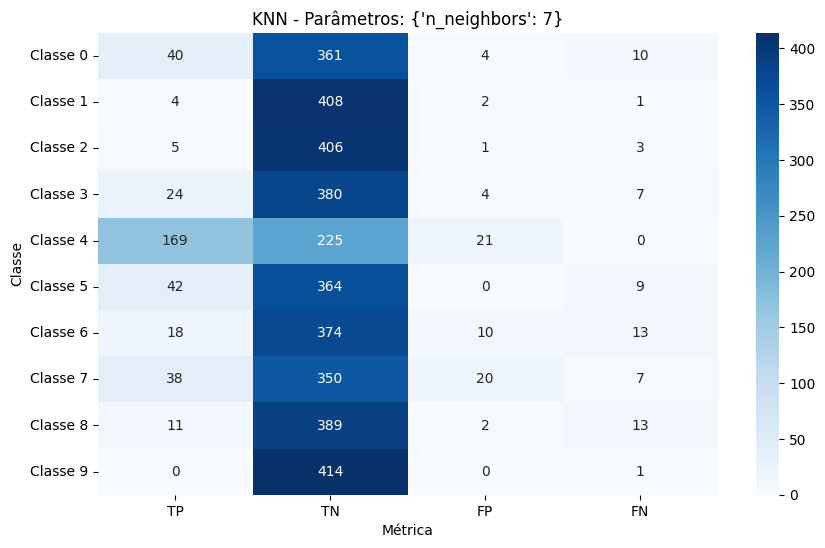

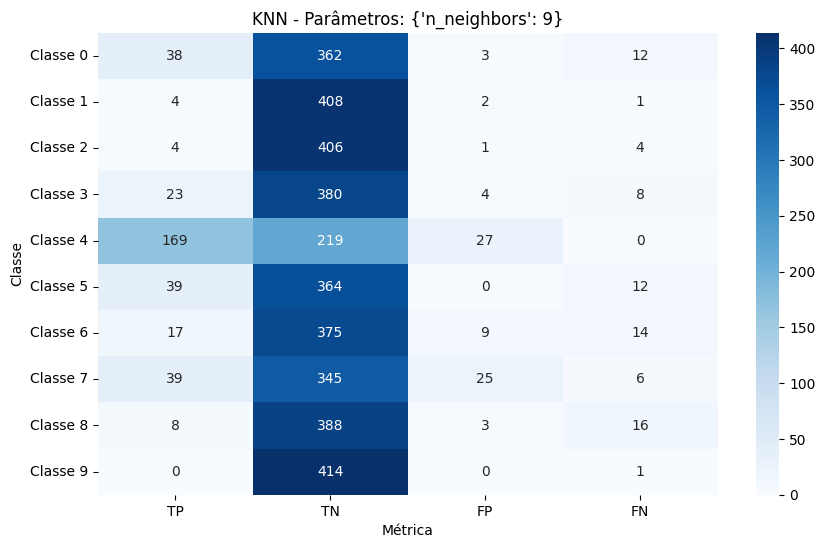

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_metrics_per_class(data, class_names=None):
    y_pred = data["y_pred"]
    y_val = data["y_val"]
    cm = confusion_matrix(y_val, y_pred)

    metrics = {}
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        class_label = class_names[i] if class_names else f"Classe {i}"
        metrics[class_label] = {"TP": tp, "TN": tn, "FP": fp, "FN": fn}

    return metrics

def plot_metrics_heatmap(metrics_data, title="Mapa de Calor de Métricas por Classe"):
    # Converter o dicionário de métricas para um DataFrame do pandas
    metrics_df = pd.DataFrame(metrics_data).T

    plt.figure(figsize=(10, 6))
    sns.heatmap(metrics_df, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Métrica")
    plt.ylabel("Classe")
    plt.show()

# Exemplo de uso com seus dados de teste para SVM
for data in svm_test:
    metrics_per_class = get_metrics_per_class(data)
    plot_metrics_heatmap(metrics_per_class, title=f"SVM - Parâmetros: {data['params']}")

# Repita para mlp_test, rf_test, knn_test conforme necessário
for data in mlp_test:
    metrics_per_class = get_metrics_per_class(data)
    plot_metrics_heatmap(metrics_per_class, title=f"MLP - Parâmetros: {data['params']}")

for data in rf_test:
    metrics_per_class = get_metrics_per_class(data)
    plot_metrics_heatmap(metrics_per_class, title=f"Random Forest - Parâmetros: {data['params']}")

for data in knn_test:
    metrics_per_class = get_metrics_per_class(data)
    plot_metrics_heatmap(metrics_per_class, title=f"KNN - Parâmetros: {data['params']}")